In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# adjust depending on exact filename in dataset
df = pd.read_csv('predictive_maintenance.csv')  # change name if needed
df.head(), df.shape


(   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
 0                    1551         42.8                0                0    0   
 1                    1408         46.3                3                0    0   
 2                    1498         49.4                5                0    0   
 3                    1433         39.5                7                0    0   
 4                    1408         40.0                9                0    0   
 
    HDF  PWF  OSF  RNF  
 0    0    0    0    0  
 1    0    0    

In [2]:
# Basic info
print(df.columns)
print(df.info())
display(df.describe().T)

# Check missing values
print("Missing values per column:")
print(df.isna().sum())


Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  


,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


Missing values per column:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64


In [3]:
# Identify the target column (common names: 'Failure', 'Machine failure', 'Target', etc.)
# Let's try common possibilities:
possible_targets = ['Failure', 'failure', 'machine_status', 'target', 'Machine failure']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    # list candidate columns for you to choose manually
    print("No obvious target column detected. Columns are:", df.columns.tolist())
else:
    print("Detected target column:", target_col)
    print(df[target_col].value_counts(normalize=True))


Detected target column: Machine failure
Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Example: automatically select numeric features and optional categorical ones
target = target_col  # replace if needed
X = df.drop(columns=[target])
y = df[target].astype(int)  # convert to int if it's boolean/str

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


Numerical cols: ['UDI', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
Categorical cols: ['Product ID', 'Type']


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support

rf = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1] if hasattr(rf.named_steps['clf'], 'predict_proba') else None

print(classification_report(y_test, y_pred))
if y_proba is not None:
    print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1932
           1       1.00      0.97      0.99        68

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC: 0.990397789550603


HDF                        0.142702
OSF                        0.120736
PWF                        0.111737
Torque [Nm]                0.084416
TWF                        0.058302
Rotational speed [rpm]     0.057444
Tool wear [min]            0.033196
UDI                        0.023301
Air temperature [K]        0.021057
Process temperature [K]    0.015838
Product ID_L53658          0.003132
Product ID_M17609          0.002960
Product ID_M18904          0.002929
Product ID_M20396          0.002688
Product ID_L53121          0.002681
Type_L                     0.002534
Type_M                     0.002418
Product ID_H30851          0.002266
Product ID_M19544          0.002213
Product ID_L55379          0.001709
Product ID_L53352          0.001704
Product ID_L51649          0.001653
Product ID_L55789          0.001635
Product ID_L51465          0.001597
Product ID_L48943          0.001595
Product ID_L54690          0.001557
Product ID_L51996          0.001556
Product ID_L51182          0

Text(0.5, 1.0, 'Top feature importances')

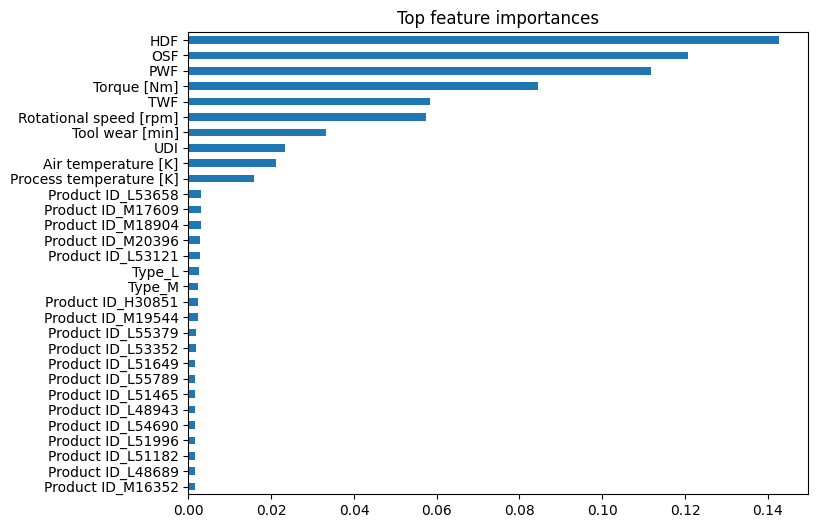

In [6]:
# If RandomForest, get feature importances (after preprocessing we need column names)
import numpy as np

# get feature names after preprocessing
def get_feature_names(column_transformer):
    # utility to extract names: only works for the pipelines used above
    output_features = []
    for name, transformer, columns in column_transformer.transformers_:
        if name == 'num':
            output_features += columns
        elif name == 'cat':
            # get OHE feature names
            ohe = transformer.named_steps['ohe']
            cats = ohe.get_feature_names_out(columns)
            output_features += list(cats)
    return output_features

feature_names = get_feature_names(preprocessor)
importances = rf.named_steps['clf'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
print(feat_imp)
feat_imp.plot(kind='barh', figsize=(8,6)); plt.gca().invert_yaxis(); plt.title('Top feature importances')


In [10]:
# Save the trained RandomForest pipeline for deployment
import joblib
# 'rf' is assumed to be the pipeline from Cell 7 (preprocessor + RandomForest)
joblib.dump(rf, 'pm_model_rf_pipeline.joblib')
print("Saved model pipeline to pm_model_rf_pipeline.joblib")


Saved model pipeline to pm_model_rf_pipeline.joblib


In [11]:
# Quick check on a few test rows
import pandas as pd
# If X_test exists from earlier cells:
sample = X_test.head(5).copy()
probs = rf.predict_proba(sample)[:,1]  # probability of positive/failure
preds = rf.predict(sample)

out = sample.reset_index(drop=True)
out['failure_prob'] = probs
out['predicted_failure'] = preds
out


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,failure_prob,predicted_failure
0,2998,L50177,L,300.5,309.8,1345,62.7,153,0,0,0,0,0,0.020,0
1,4872,L52051,L,303.7,312.4,1513,40.1,135,0,0,0,0,0,0.000,0
2,3859,L51038,L,302.5,311.4,1559,37.6,209,0,0,0,0,0,0.025,0
3,952,H30365,H,295.6,306.3,1509,35.8,60,0,0,0,0,0,0.005,0
4,6464,H35877,H,300.5,310.0,1358,60.4,102,0,0,0,0,0,0.025,0
